In [1]:
import json 
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from glob import glob 
os.chdir('../')

def load_df(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()
    df = pd.DataFrame(list(pd.Series(data).map(eval).values))    
    return df 

def load_log_data(class_name, version, result_dir,method):

    df = pd.DataFrame()
    for i,v in enumerate(version):
        log_dir = os.path.join(result_dir,class_name,method,v,'log.txt')
        
        temp_df = load_df(log_dir)
        temp_df['hue'] = v 
        
        df = pd.concat([df,temp_df])
    
    return df 

def plot_log(data,class_name, metrics:list, figsize:tuple = (10,7)):
    
    fig, axes = plt.subplots(len(metrics),1,figsize=figsize)
    
    for ax, metric in zip(axes, metrics):
        sns.lineplot(
            x = 'epoch',
            y = metric,
            data = data,
            hue = data['hue'],
            ax = ax 
        )
        
    fig.suptitle(class_name)
    plt.show()
    
def read_txt(log_dir):
    with open(log_dir, 'r') as f: 
        data = f.readlines()    
    df = pd.DataFrame([eval(d) for d in data]) 
    return df 

In [2]:
version = ['noisedad_nn5-*-sampling_ratio_0.1-anomaly_ratio_0.*-n_query_0']
result_dir = './results/MVTecLoco/'
method = 'PatchCore'

log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    auroc_list[class_name] = {'image_auroc':auroc[0], 'pixel_auroc':auroc[1]}
    temp_df = pd.DataFrame(auroc_list).T.reset_index().sort_values(by='index').reset_index(drop=True)
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    
    
    
df.reset_index(drop=True,inplace=True)
df = df.sort_values(by=['index','anomaly_ratio']).reset_index(drop=True)
df.groupby(['index','sampling_method','anomaly_ratio'])[['image_auroc','pixel_auroc']].mean()

image_auroc  pixel_auroc
index               sampling_method anomaly_ratio                          
breakfast_box       gaussian        0.00              0.754045     0.902588
                                    0.05              0.757186     0.904290
                                    0.10              0.753855     0.903951
                                    0.15              0.762802     0.902082
                                    0.20              0.748810     0.891169
...                                                        ...          ...
splicing_connectors nearest         0.00              0.667546     0.669913
                                    0.05              0.669908     0.670846
                                    0.10              0.678728     0.664907
                                    0.15              0.699354     0.662493
                                    0.20              0.695187     0.653087

[100 rows x 2 columns]

# Anomaly Type(structural, logical) 에 따라 

In [4]:
log_dirs = glob(os.path.join(result_dir,method,'*',version[0],'seed_0','log.txt'))
df = pd.DataFrame()

for log_dir in log_dirs:
    auroc_list = {}
    class_name = log_dir.split('/')[4]
    
    data = load_df(log_dir)
    auroc = pd.DataFrame(data['test_metrics'][0]).query('index == "auroc"').values[0]
    data = pd.DataFrame(data['test_metrics'][0]).iloc[3,:].reset_index()
    data['structural_anomalies'] = data['loco_auroc'].apply(lambda x : x['structural_anomalies'])
    data['logical_anomalies'] = data['loco_auroc'].apply(lambda x : x['logical_anomalies'])
    data.drop(columns = 'loco_auroc',inplace=True)
    temp_df = data 
    
    temp_df['class'] = class_name 
    temp_df['anomaly_ratio'] = float(log_dir.split('/')[-3].split('-')[-2].split('_')[-1])
    temp_df['sampling_method'] = log_dir.split('/')[-3].split('-')[1]
    
    df = pd.concat([df,temp_df])
    
    

In [5]:
df = df.melt(['index','class','anomaly_ratio','sampling_method'])

# sampling method identity,랑 lof만 남기기 
df = df[(df['sampling_method'] =='identity') | (df['sampling_method'] =='lof')].reset_index(drop=True)

# 이름 바꾸기 
df.loc[df['sampling_method']=='identity','sampling_method'] = 'PatchCore'
df.loc[df['sampling_method']=='lof','sampling_method'] = 'SoftPatch'

plot_df = df.groupby(['variable','anomaly_ratio','sampling_method','index','class'])['value'].mean().reset_index()
# plot_df = plot_df[plot_df['index'] == 'img_level'].reset_index(drop=True)

result = plot_df.pivot_table(index=['class','sampling_method','index'],columns=['variable','anomaly_ratio'],values='value')
result

variable                                      logical_anomalies            \
anomaly_ratio                                              0.00      0.05   
class               sampling_method index                                   
breakfast_box       PatchCore       img_level          0.840875  0.851056   
                                    pix_level          0.899787  0.881489   
                    SoftPatch       img_level          0.848605  0.847097   
                                    pix_level          0.892956  0.894504   
juice_bottle        PatchCore       img_level          0.891673  0.893515   
                                    pix_level          0.909888  0.909107   
                    SoftPatch       img_level          0.891571  0.891673   
                                    pix_level          0.909610  0.909298   
pushpins            PatchCore       img_level          0.657479  0.632764   
                                    pix_level          0.572364  0.512823   
                    SoftPatch       img_level          0.636387  0.629400   
                                    pix_level          0.543619  0.530212   
screw_bag           PatchCore       img_level          0.628671  0.594860   
                                    pix_level          0.733940  0.733482   
                    SoftPatch       img_level          0.617230  0.601947   
                                    pix_level          0.734483  0.733215   
splicing_connectors PatchCore       img_level          0.758078  0.745769   
                                    pix_level          0.650303  0.651991   
                    SoftPatch       img_level          0.736300  0.733223   
                                    pix_level          0.652115  0.653831   

variable                                                                     \
anomaly_ratio                                      0.10      0.15      0.20   
class               sampling_method index                                     
breakfast_box       PatchCore       img_level  0.787707  0.737745  0.739253   
                                    pix_level  0.867113  0.845005  0.841262   
                    SoftPatch       img_level  0.845965  0.834087  0.815045   
                                    pix_level  0.893618  0.894725  0.891766   
juice_bottle        PatchCore       img_level  0.890957  0.886047  0.887582   
                                    pix_level  0.912848  0.906739  0.906642   
                    SoftPatch       img_level  0.888502  0.885945  0.892696   
                                    pix_level  0.912701  0.910670  0.912935   
pushpins            PatchCore       img_level  0.603649  0.595756  0.581910   
                                    pix_level  0.506518  0.487502  0.470150   
                    SoftPatch       img_level  0.620600  0.590709  0.621894   
                                    pix_level  0.534621  0.503355  0.497892   
screw_bag           PatchCore       img_level  0.622609  0.575649  0.585297   
                                    pix_level  0.732572  0.732515  0.730801   
                    SoftPatch       img_level  0.596226  0.594177  0.584870   
                                    pix_level  0.733382  0.732792  0.732659   
splicing_connectors PatchCore       img_level  0.750858  0.744585  0.735235   
                                    pix_level  0.644299  0.632419  0.633701   
                    SoftPatch       img_level  0.727778  0.736537  0.741508   
                                    pix_level  0.649740  0.647246  0.636282   

variable                                      structural_anomalies            \
anomaly_ratio                                                 0.00      0.05   
class               sampling_method index                                      
breakfast_box       PatchCore       img_level             0.804498  0.777586   
                                    pix_level             0.935337  0.929140   
          

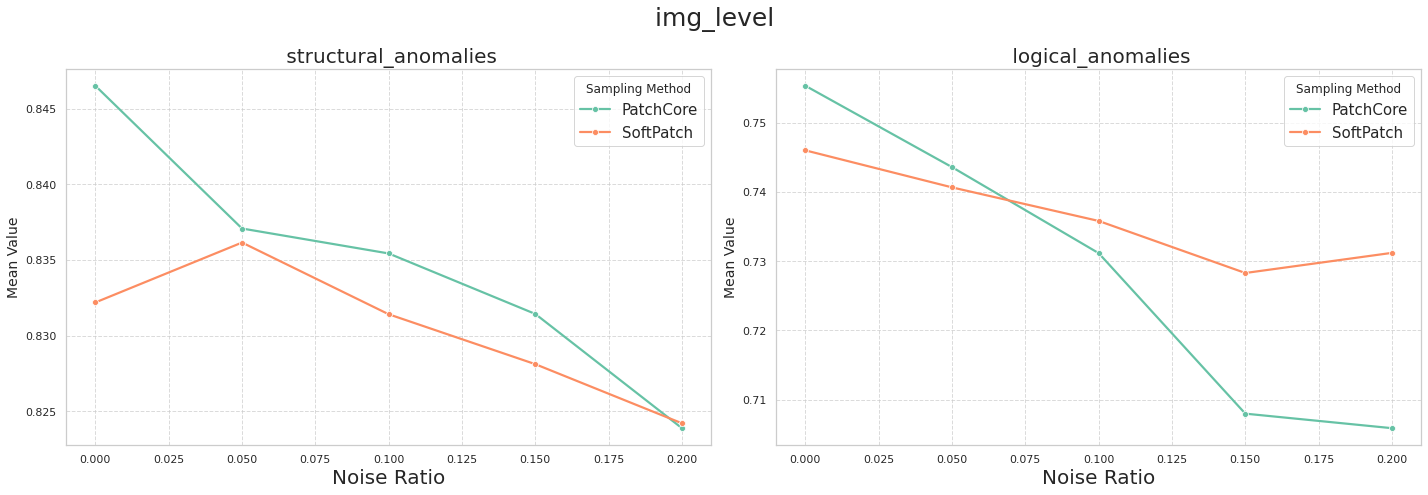

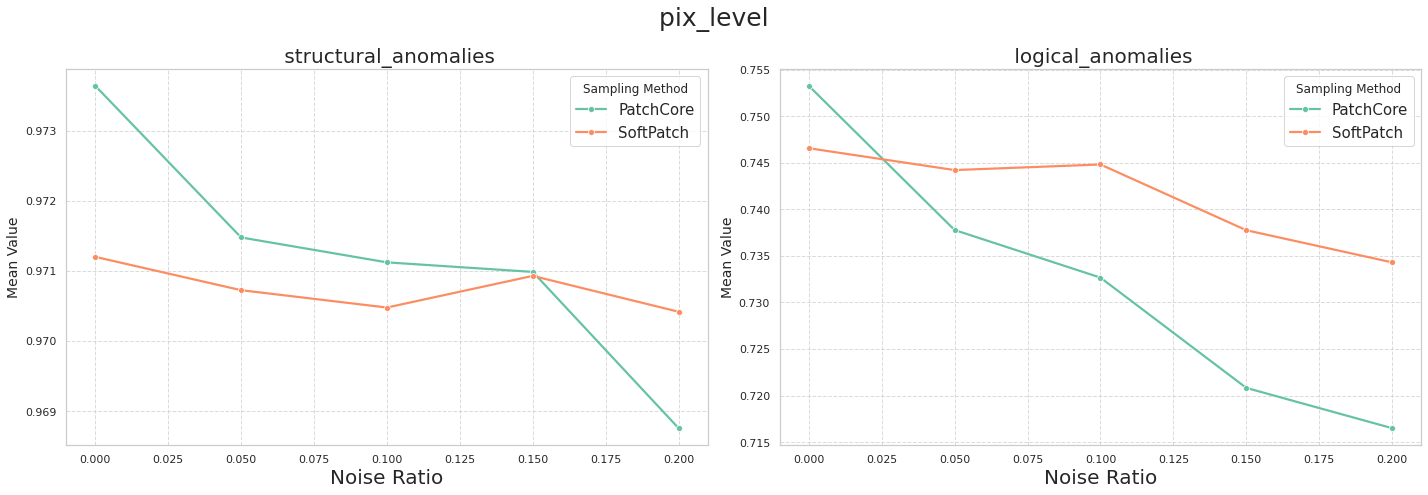

In [10]:
sns.set(style="whitegrid")  # Set the background style

for level in ['img_level','pix_level']:
    plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index'])['value'].mean().reset_index()
    plot_df = plot_df[plot_df['index'] == level].reset_index(drop=True)

    fig,axes = plt.subplots(1,2, figsize=(20,7))

    for i, a_type in enumerate(['structural_anomalies','logical_anomalies']):
        sns.lineplot(
            x = 'anomaly_ratio',
            y = 'value',
            hue = 'sampling_method',
            data = plot_df[(plot_df['variable'] == a_type)],
            ax = axes[i],
            linewidth=2.2,
            markers=True,  # Show markers at data points
            marker='o',    # Marker style
            palette='Set2',  # Color palette
            errorbar=None  # Disable confidence intervals
        )   
        axes[i].legend(fontsize=15, title='Sampling Method')
        axes[i].set_title(f"{a_type}", size=25)
        axes[i].set_xlabel("Noise Ratio", size=20)
        axes[i].set_ylabel("Mean Value", size=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        axes[i].set_title(f" {a_type}",size=20)

    fig.suptitle(f' {level} ', fontsize=25)
    plt.tight_layout()
    plt.show()


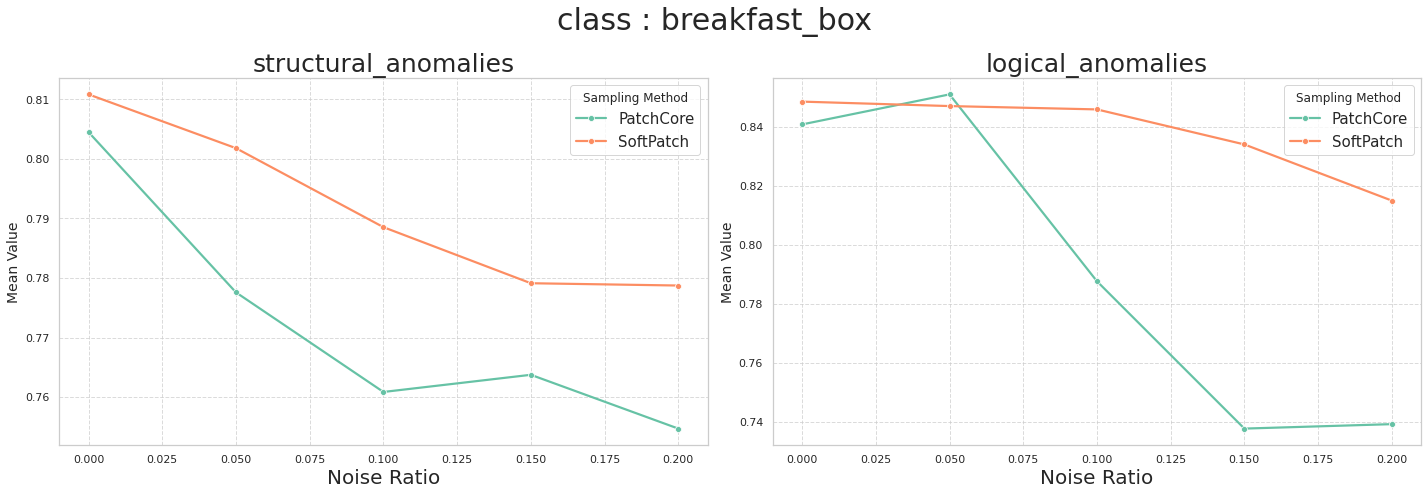

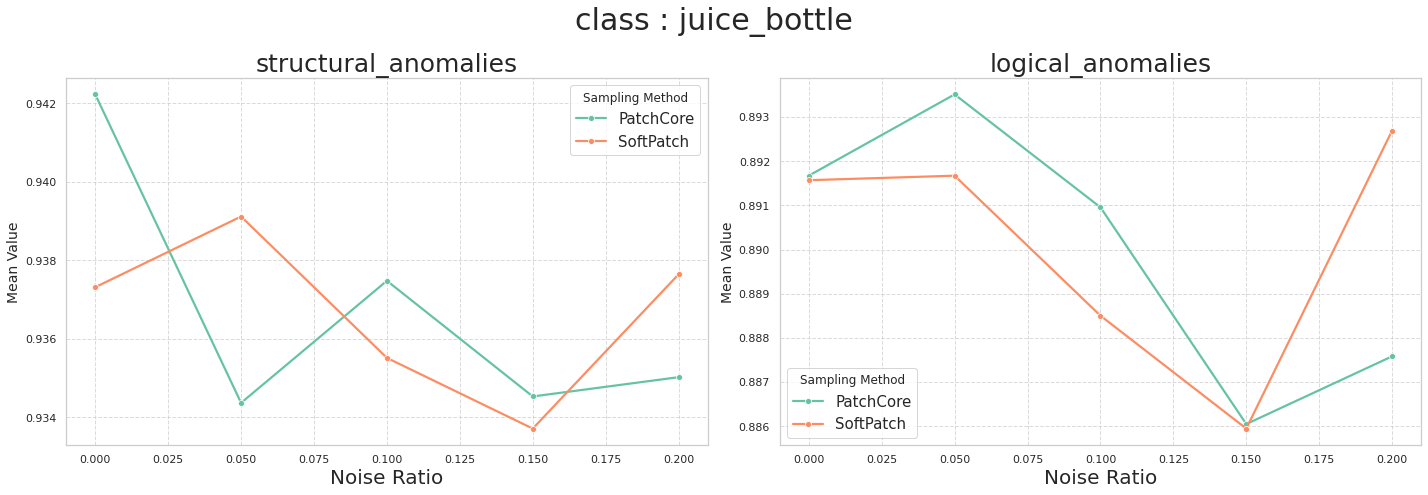

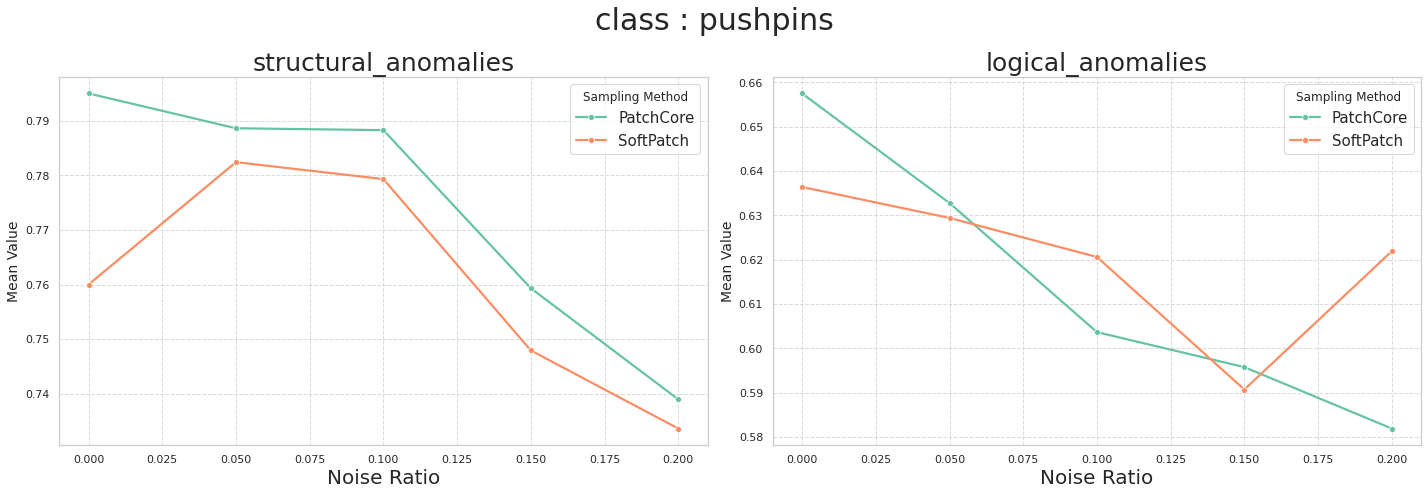

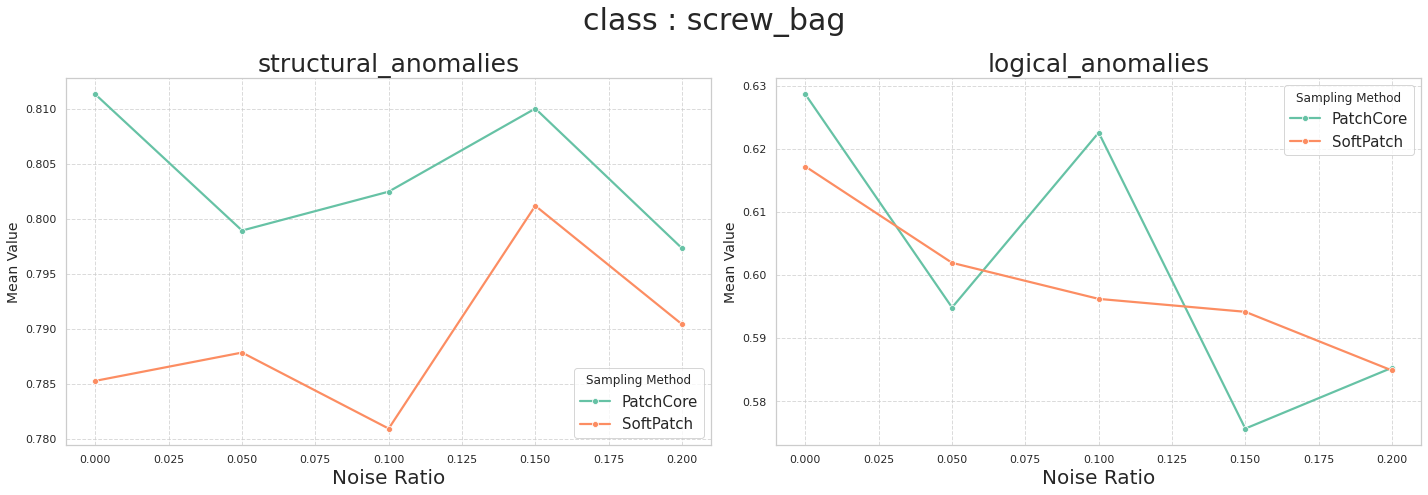

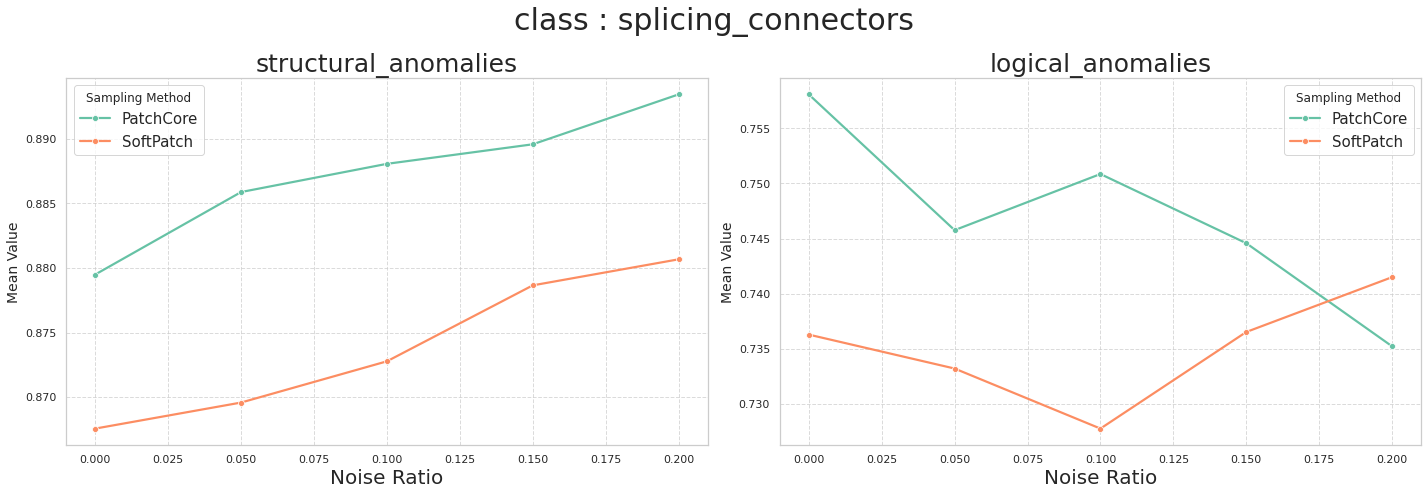

In [14]:
sns.set(style="whitegrid")  # Set the background style

plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index','class'])['value'].mean().reset_index()
plot_df = plot_df[plot_df['index'] == 'img_level'].reset_index(drop=True)

for class_name in plot_df['class'].unique():
    fig,axes = plt.subplots(1,2, figsize=(20,7))

    for i, a_type in enumerate(['structural_anomalies','logical_anomalies']):
        sns.lineplot(
            x = 'anomaly_ratio',
            y = 'value',
            hue = 'sampling_method',
            data = plot_df[(plot_df['variable'] == a_type) & (plot_df['class']==class_name)],
            ax = axes[i],
        linewidth=2.2,
        markers=True,  # Show markers at data points
        marker='o',    # Marker style
        palette='Set2',  # Color palette
        errorbar=None  # Disable confidence intervals
    )
        axes[i].legend(fontsize=15, title='Sampling Method')
        axes[i].set_title(f"{a_type}", size=25)
        axes[i].set_xlabel("Noise Ratio", size=20)
        axes[i].set_ylabel("Mean Value", size=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
    fig.suptitle(f'class : {class_name}',size=30)
    plt.tight_layout()
    plt.show()


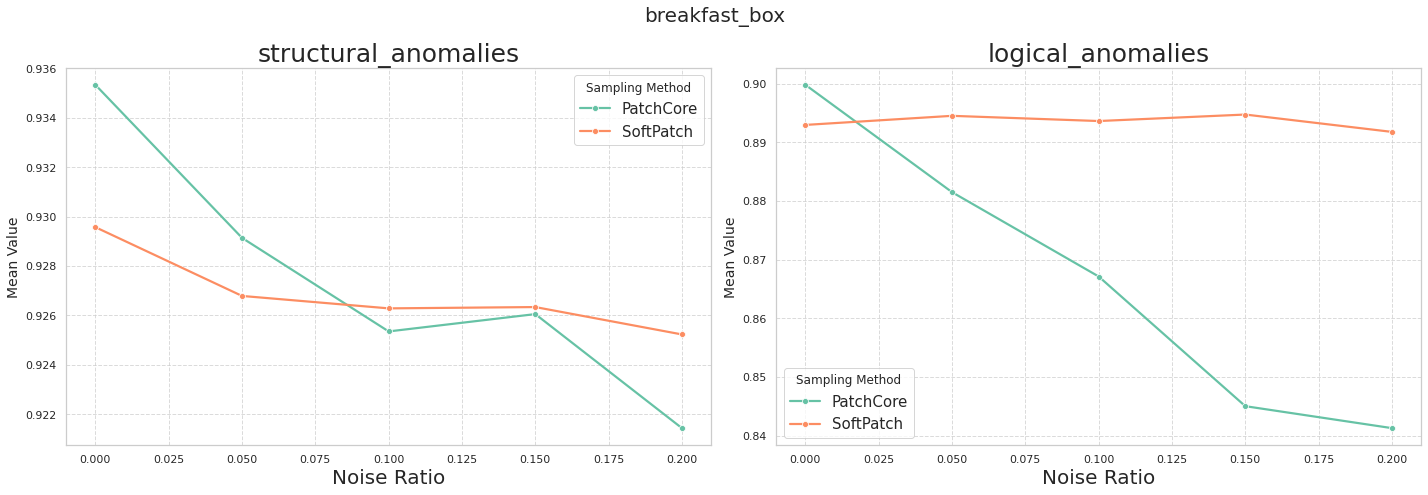

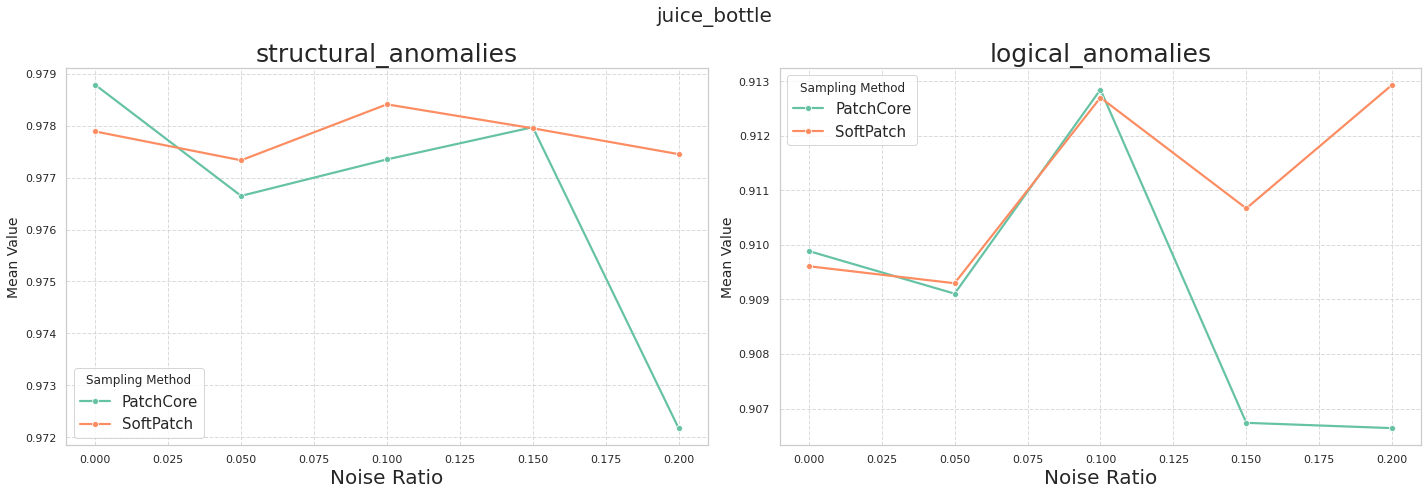

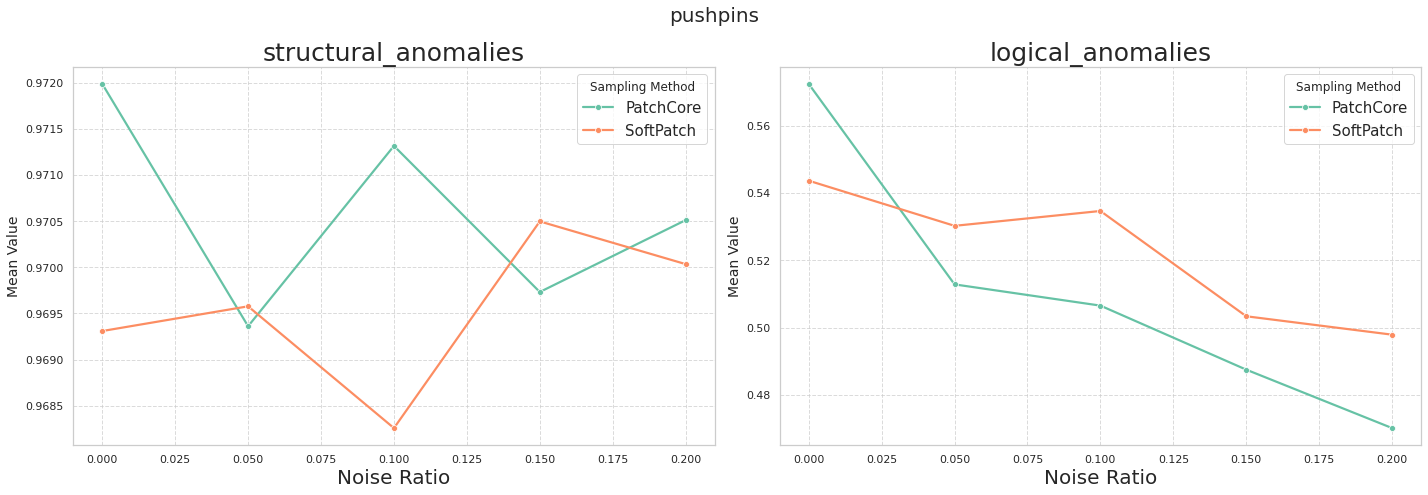

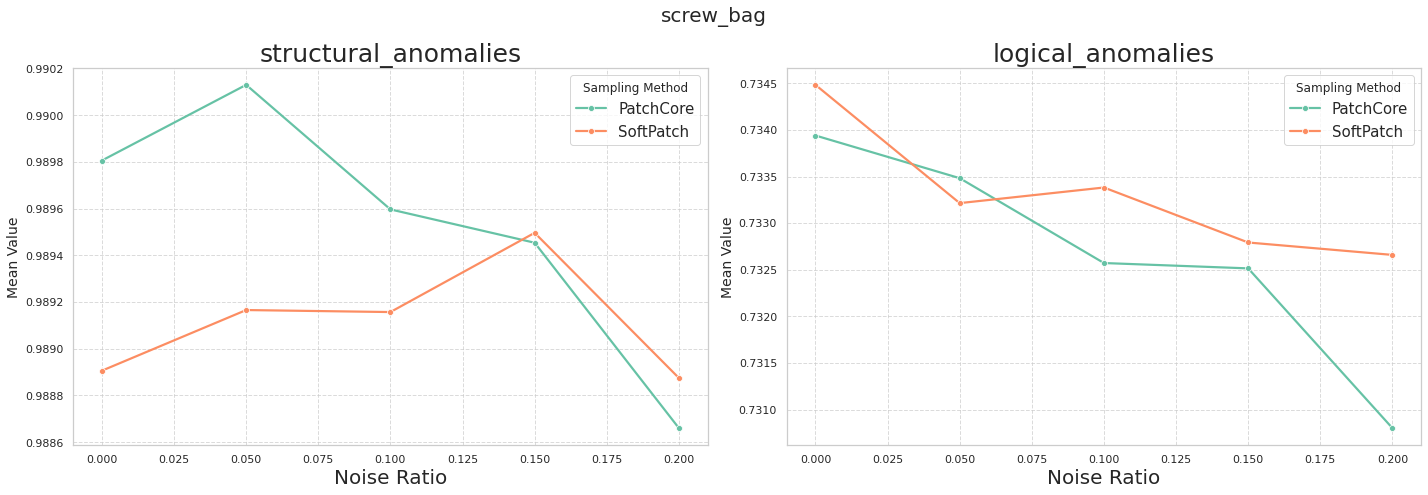

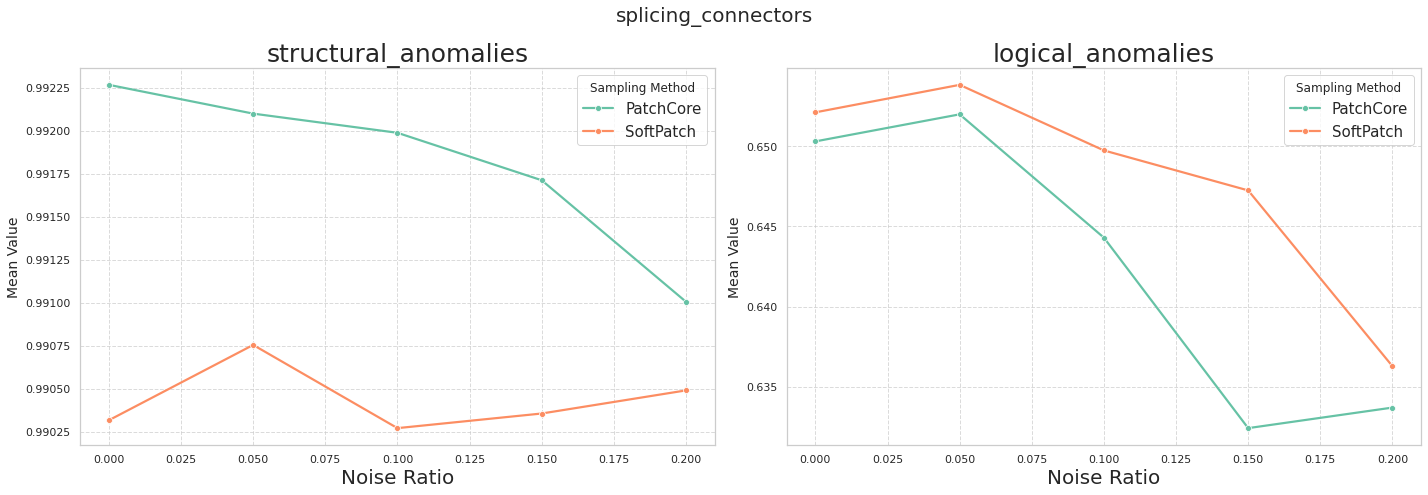

In [15]:
sns.set(style="whitegrid")  # Set the background style

plot_df = df.groupby(['variable','sampling_method','anomaly_ratio','index','class'])['value'].mean().reset_index()
plot_df = plot_df[plot_df['index'] == 'pix_level'].reset_index(drop=True)

for class_name in plot_df['class'].unique():
    fig,axes = plt.subplots(1,2, figsize=(20,7))

    for i, a_type in enumerate(['structural_anomalies','logical_anomalies']):
        sns.lineplot(
            x = 'anomaly_ratio',
            y = 'value',
            hue = 'sampling_method',
            data = plot_df[(plot_df['variable'] == a_type) & (plot_df['class']==class_name)],
            ax = axes[i],
        linewidth=2.2,
        markers=True,  # Show markers at data points
        marker='o',    # Marker style
        palette='Set2',  # Color palette
        errorbar=None  # Disable confidence intervals
    )
        axes[i].legend(fontsize=15, title='Sampling Method')
        axes[i].set_title(f"{a_type}", size=25)
        axes[i].set_xlabel("Noise Ratio", size=20)
        axes[i].set_ylabel("Mean Value", size=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
    fig.suptitle(class_name,size=20)
    plt.tight_layout()
    plt.show()


# Noiseless 

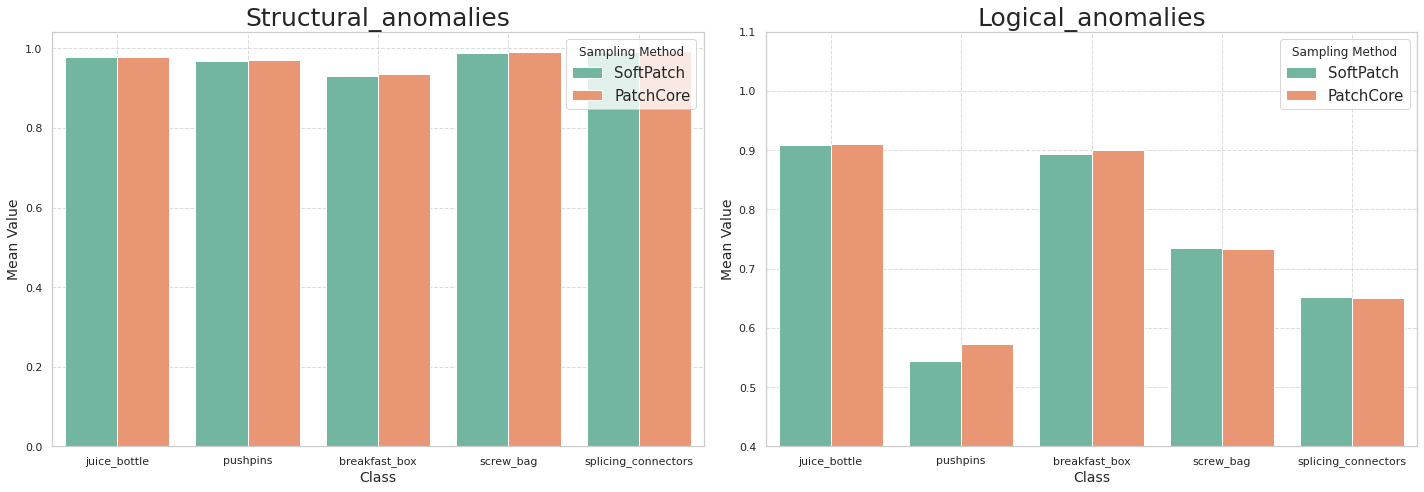

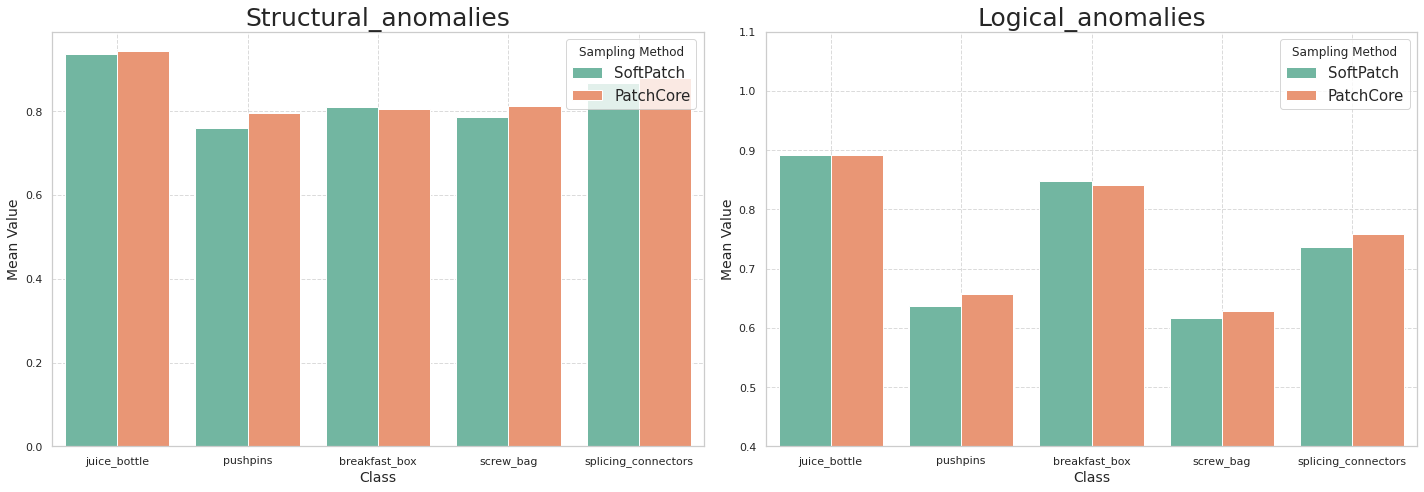

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing DataFrame and code
# ...

# Styling
sns.set(style="whitegrid")  # Set the background style

for level in ['pix_level','img_level']:
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    for col, anomaly_type in enumerate(['structural_anomalies', 'logical_anomalies']):
        # Filter data for the specific anomaly type
        plot_df_bar = df[(df['anomaly_ratio'] == 0.00) & (df['variable'] == anomaly_type)].reset_index(drop=True)

        # Bar plot
        sns.barplot(
            x='class',
            y='value',
            hue='sampling_method',
            data=plot_df_bar[plot_df_bar['index']==level],
            palette='Set2',
            ax=axes[col]  # Assign the subplot to the current column
        )

        # Customize subplot
        axes[col].set_title(anomaly_type.capitalize(), size=25)
        axes[col].set_xlabel("Class", size=14)
        axes[col].set_ylabel("Mean Value", size=14)
        axes[col].legend(fontsize=15, title='Sampling Method')
        axes[col].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.ylim(0.4,1.1)
    # Show the plot
    plt.show()


In [20]:
df

,index,class,anomaly_ratio,sampling_method,variable,value
0,img_level,juice_bottle,0.05,PatchCore,structural_anomalies,0.934370
1,pix_level,juice_bottle,0.05,PatchCore,structural_anomalies,0.976649
2,img_level,juice_bottle,0.15,SoftPatch,structural_anomalies,0.933715
3,pix_level,juice_bottle,0.15,SoftPatch,structural_anomalies,0.977951
4,img_level,juice_bottle,0.10,SoftPatch,structural_anomalies,0.935516
...,...,...,...,...,...,...
195,pix_level,splicing_connectors,0.15,PatchCore,logical_anomalies,0.632419
196,img_level,splicing_connectors,0.10,PatchCore,logical_anomalies,0.750858
197,pix_level,splicing_connectors,0.10,PatchCore,logical_anomalies,0.644299
198,img_level,splicing_connectors,0.00,PatchCore,logical_anomalies,0.758078


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing DataFrame and code
# ...

# Styling
sns.set(style="whitegrid")  # Set the background style

for level in ['pix_level','img_level']:
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    for col, anomaly_type in enumerate(['structural_anomalies', 'logical_anomalies']):
        # Filter data for the specific anomaly type
        plot_df_bar = df[(df['sampling_method'] == 'SoftPatch') & (df['anomaly_ratio'] == 0.00)].reset_index(drop=True)

        # Bar plot
        sns.barplot(
            x='class',
            y='value',
            hue='variable',
            data=plot_df_bar[plot_df_bar['index']==level],
            palette='Set2',
            ax=axes[col]  # Assign the subplot to the current column
        )

        # Customize subplot
        axes[col].set_title(anomaly_type.capitalize(), size=25)
        axes[col].set_xlabel("Class", size=14)
        axes[col].set_ylabel("Mean Value", size=14)
        axes[col].legend(fontsize=15, title='Sampling Method')
        axes[col].grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.ylim(0.4,1.1)
    # Show the plot
    plt.show()


In [22]:
df

,index,class,anomaly_ratio,sampling_method,variable,value
0,img_level,juice_bottle,0.05,PatchCore,structural_anomalies,0.934370
1,pix_level,juice_bottle,0.05,PatchCore,structural_anomalies,0.976649
2,img_level,juice_bottle,0.15,SoftPatch,structural_anomalies,0.933715
3,pix_level,juice_bottle,0.15,SoftPatch,structural_anomalies,0.977951
4,img_level,juice_bottle,0.10,SoftPatch,structural_anomalies,0.935516
...,...,...,...,...,...,...
195,pix_level,splicing_connectors,0.15,PatchCore,logical_anomalies,0.632419
196,img_level,splicing_connectors,0.10,PatchCore,logical_anomalies,0.750858
197,pix_level,splicing_connectors,0.10,PatchCore,logical_anomalies,0.644299
198,img_level,splicing_connectors,0.00,PatchCore,logical_anomalies,0.758078


In [27]:
df

,index,class,anomaly_ratio,sampling_method,variable,value
0,img_level,juice_bottle,0.05,PatchCore,structural_anomalies,0.934370
1,pix_level,juice_bottle,0.05,PatchCore,structural_anomalies,0.976649
2,img_level,juice_bottle,0.15,SoftPatch,structural_anomalies,0.933715
3,pix_level,juice_bottle,0.15,SoftPatch,structural_anomalies,0.977951
4,img_level,juice_bottle,0.10,SoftPatch,structural_anomalies,0.935516
...,...,...,...,...,...,...
195,pix_level,splicing_connectors,0.15,PatchCore,logical_anomalies,0.632419
196,img_level,splicing_connectors,0.10,PatchCore,logical_anomalies,0.750858
197,pix_level,splicing_connectors,0.10,PatchCore,logical_anomalies,0.644299
198,img_level,splicing_connectors,0.00,PatchCore,logical_anomalies,0.758078


In [32]:
pivot_df = df[df['index']=='img_level'].pivot_table(index=['sampling_method','variable'],columns=['class','anomaly_ratio'],values='value')
pivot_df = pivot_df.loc['PatchCore'].values - pivot_df.loc['SoftPatch']

log_pivot = pivot_df.loc['logical_anomalies'].reset_index()
log_pivot['variable']= 'logical_anomalies'
log_pivot.columns = ['class','anomaly_ratio','value','variable']

str_pivot = pivot_df.loc['structural_anomalies'].reset_index()
str_pivot['variable']= 'structural_anomalies'
str_pivot.columns = ['class','anomaly_ratio','value','variable']
pivot_df = pd.concat([log_pivot,str_pivot])

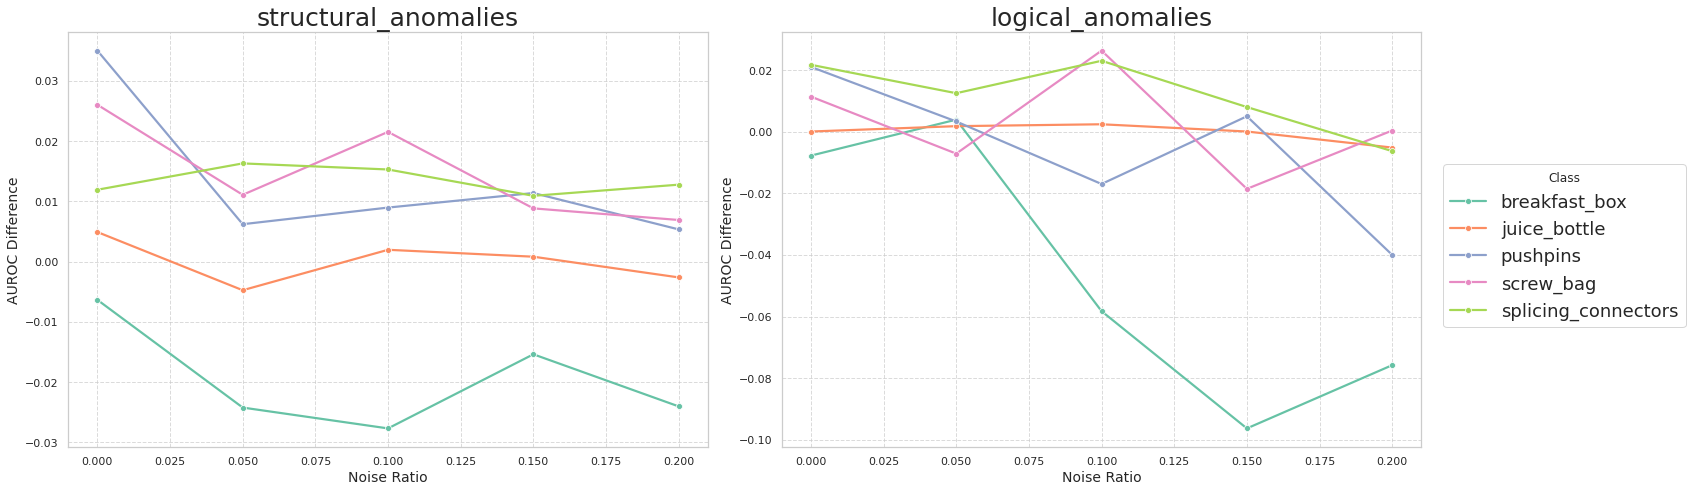

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing DataFrame and code
# ...

# Styling
sns.set(style="whitegrid")  # Set the background style

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for i, a_type in enumerate(['structural_anomalies', 'logical_anomalies']):
    sns.lineplot(
        x='anomaly_ratio',
        y='value',
        hue='class',
        data=pivot_df[pivot_df['variable'] == a_type],
        linewidth=2.2,
        markers=True,  # Show markers at data points
        marker='o',    # Marker style
        palette='Set2',  # Color palette
        errorbar=None,  # Disable confidence intervals,
        ax = axes[i]
    )
    axes[i].set_title(f"{a_type}", size=25)
    axes[i].set_xlabel("Noise Ratio", size=14)
    axes[i].set_ylabel("AUROC Difference", size=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].legend().set_visible(False)

# Adjust legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=18, title='Class', bbox_to_anchor=(1.0, 0.5), loc='center left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
